# GOLEM Fast Spectrometry Analysis

This notebook demonstrates analysis of GOLEM tokamak diagnostic data using the `golem_data_loader` module.

## Features of the data loader:
- **Type-safe**: Full type annotations for better IDE support
- **Robust error handling**: Automatic retries with configurable delays
- **Flexible**: Load all or specific spectroscopy lines
- **Well-documented**: Comprehensive docstrings and examples
- **Easy to use**: Simple API with sensible defaults

In [91]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
from scipy import fft

# Import the GOLEM data loader module
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,  # base font size
        "axes.labelsize": 18,  # x/y labels
        "axes.titlesize": 18,  # subplot titles
        "xtick.labelsize": 14,  # x tick labels
        "ytick.labelsize": 14,  # y tick labels
        "legend.fontsize": 14,  # legends
        "figure.titlesize": 16,  # suptitle
    }
)


In [92]:
shotno = 50710

## Load Data from GOLEM Web Server

Using the `golem_data_loader` module to fetch diagnostic data with automatic retry logic and error handling.

In [93]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format for backward compatibility
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2026-01-10 16:30:20,148 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma start time from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/PlasmaDetection/Results/t_plasma_start
2026-01-10 16:30:20,183 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma end time from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/PlasmaDetection/Results/t_plasma_end
2026-01-10 16:30:20,184 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 1.65 - 13.70 ms
2026-01-10 16:30:20,303 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-10 16:30:20,309 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.001']
2026-01-10 16:30:20,416 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.

Hα 656.5nm: loaded 19999 rows
Cl II 479.5nm: loaded 19999 rows
He I 588nm: loaded 19999 rows
Whole: loaded 19999 rows
C II 514.5nm: loaded 3999 rows
N II 568.6nm: loaded 3999 rows
O I 777nm: loaded 3999 rows
He I 447.1nm: loaded 3999 rows


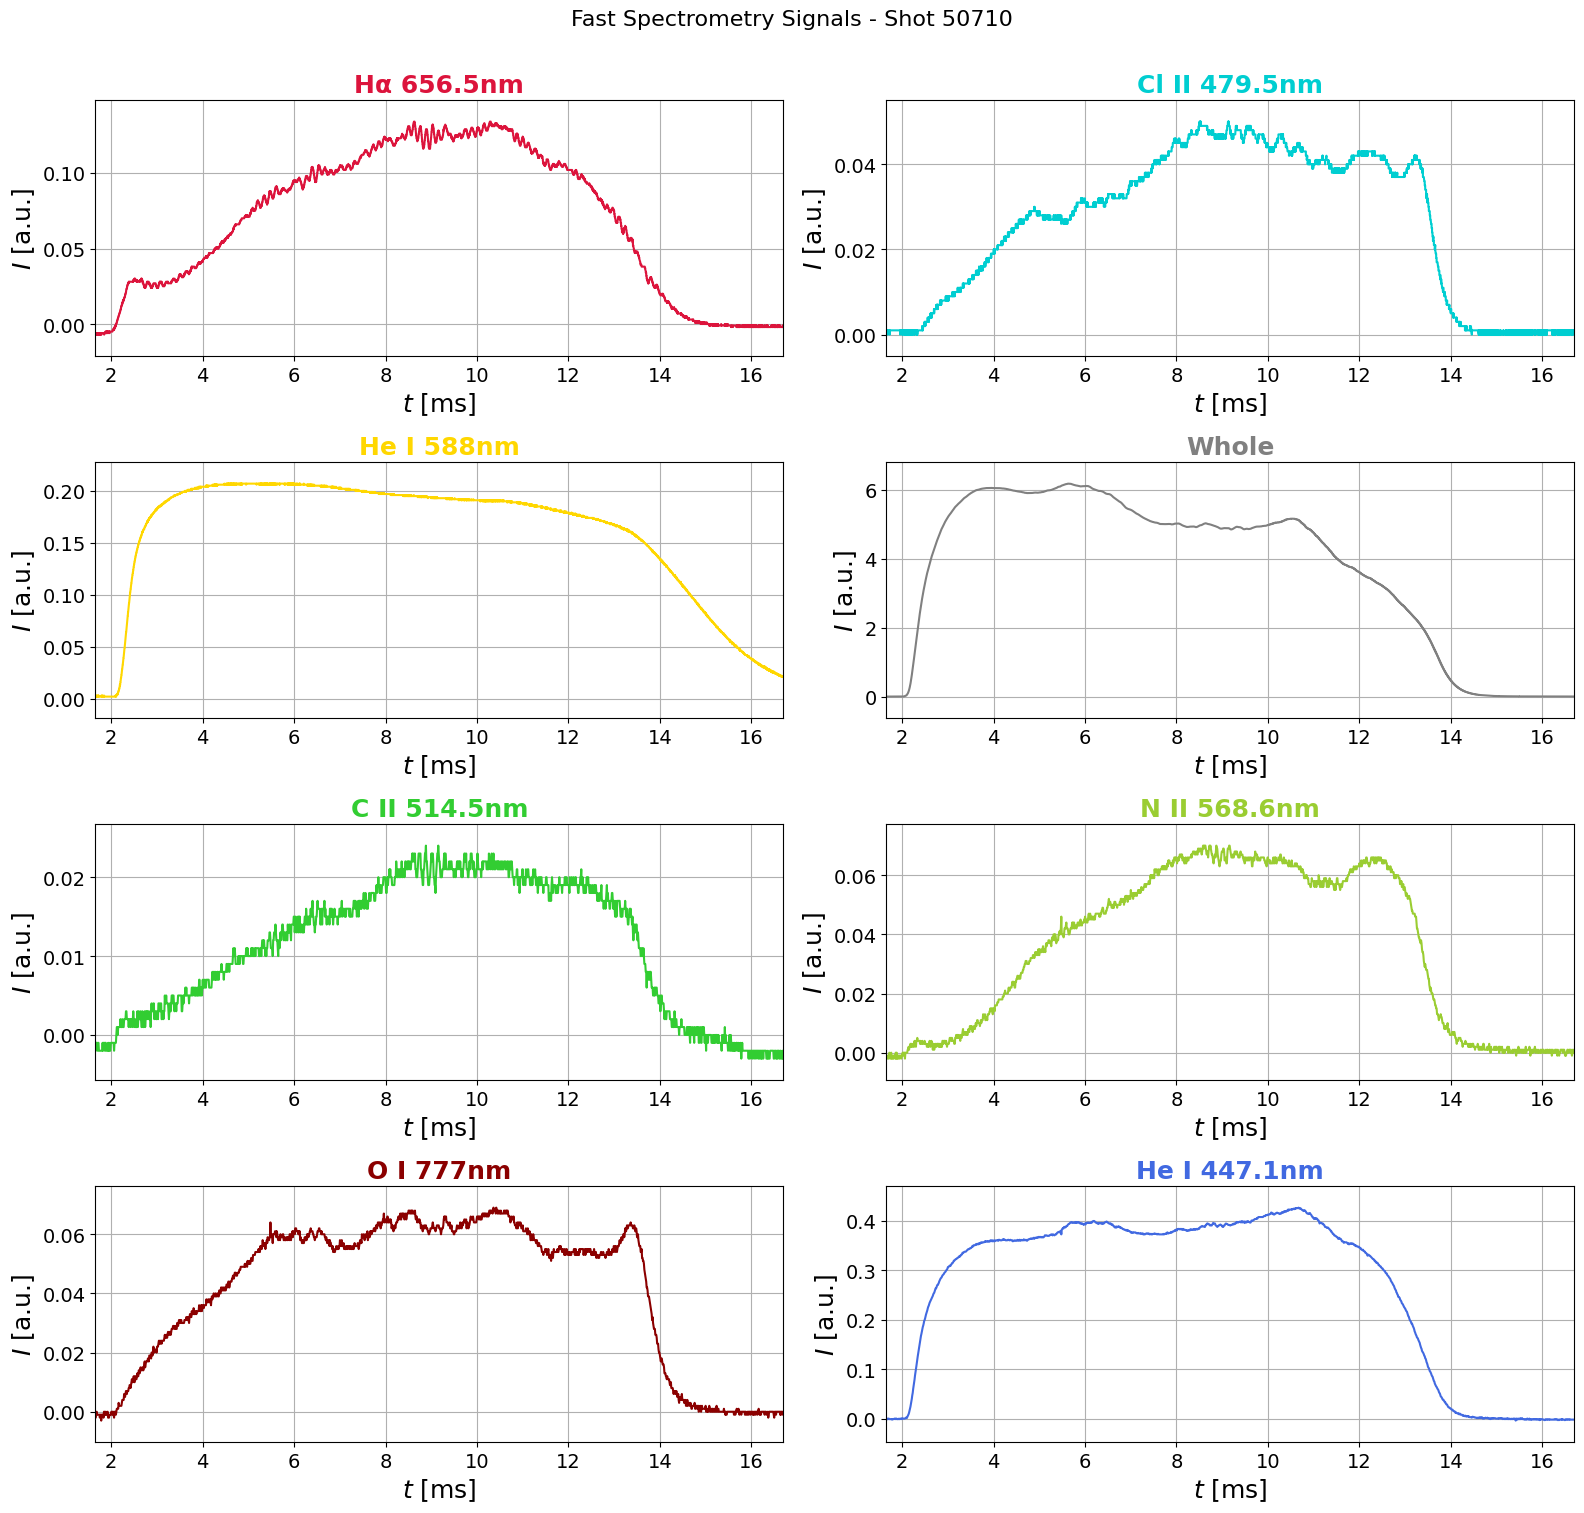

In [94]:
# Define colors for each spectral line based on their wavelengths
line_colors = {
    "Hα 656.5nm": "#DC143C",  # Crimson red (656 nm)
    "Cl II 479.5nm": "#00CED1",  # Dark turquoise (480 nm)
    "He I 588nm": "#FFD700",  # Gold (588 nm)
    "Whole": "#808080",  # Gray (all wavelengths)
    "C II 514.5nm": "#32CD32",  # Lime green (515 nm)
    "N II 568.6nm": "#9ACD32",  # Yellow-green (569 nm)
    "O I 777nm": "#8B0000",  # Dark red (777 nm)
    "He I 447.1nm": "#4169E1",  # Royal blue (447 nm)
}

# One figure, 4x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes_flat = axes.flatten()

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

for ax, (label, df) in zip(axes_flat, data.items()):
    t = df.iloc[:, 0] * 1e3  # convert to ms
    u = df.iloc[:, 1]
    color = line_colors.get(label, "black")
    ax.plot(t, u, label=label, color=color)
    ax.set_ylabel(r"$I$ [a.u.]")
    ax.set_xlabel(r"$t$ [ms]")
    ax.grid(True)
    ax.set_title(label, color=color, fontweight='bold')
    # Set xlim based on plasma timing if available
    if loader.plasma_timing:
        ax.set_xlim(loader.plasma_timing.t_plasma_start_ms, loader.plasma_timing.t_plasma_end_ms + 3)
        # Get the mask for the plasma time range to calculate ylim
        mask = (t >= loader.plasma_timing.t_plasma_start_ms) & (t <= loader.plasma_timing.t_plasma_end_ms + 3)
        if mask.any():
            u_range = u[mask]
            y_min, y_max = u_range.min(), u_range.max()
            y_margin = (y_max - y_min) * 0.1  # 10% margin
            ax.set_ylim(y_min - y_margin, y_max + y_margin)
    else:
        ax.set_xlim(0, 25)

# Figure-level title (fontsize controlled by rcParams figure.titlesize)
# Move it slightly closer to the subplots
fig.suptitle(f"Fast Spectrometry Signals - Shot {shotno}", y=0.975)

# Adjust layout; raise the top of the axes area to sit closer to the suptitle
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show the single figure with all four subplots
plt.show()

In [95]:
# Load mini-spectrometer H5 data using the loader module
h5_data = loader.load_minispectrometer_h5()

# Extract spectra and wavelengths
Spectra = h5_data.spectra
Wavelengths = h5_data.wavelengths

print(f"Loaded spectra with shape: {Spectra.shape}")
print(f"Wavelength range: {Wavelengths[0]:.2f} - {Wavelengths[-1]:.2f} nm")

2026-01-10 16:30:21,509 - golem_data_loader.golem_data_loader - INFO - Downloading H5 file to /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpys3ppcc4.h5
2026-01-10 16:30:21,601 - golem_data_loader.golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2026-01-10 16:30:21,603 - golem_data_loader.golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)
2026-01-10 16:30:21,605 - golem_data_loader.golem_data_loader - INFO - Loaded spectra: shape=(20, 2048), wavelengths: shape=(2047,)
2026-01-10 16:30:21,606 - golem_data_loader.golem_data_loader - INFO - Cleaned up temporary file: /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpys3ppcc4.h5


Loaded spectra with shape: (20, 2048)
Wavelength range: 188.11 - 1108.53 nm


In [18]:
# Load quantum efficiency data
qe_data = pd.read_csv('data/quantum_efficiency.csv')
print(f"Loaded quantum efficiency data with shape: {qe_data.shape}")
print(f"Wavelength range: {qe_data['Wavelength (nm)'].min():.2f} - {qe_data['Wavelength (nm)'].max():.2f} nm")
print("\nAvailable channels:")
print([col for col in qe_data.columns if col != 'Wavelength (nm)'])

Loaded quantum efficiency data with shape: (10656, 10)
Wavelength range: 200.00 - 2500.00 nm

Available channels:
['O777PP', 'Ha656', 'Hb486', 'Hg434', 'HeI588', 'NII569', 'HeI447', 'ClII479', 'CII515']


In [19]:
def compute_mini_spectrometer_intensity(Spectra, Wavelengths, peak_wavelength, fwhm, qe_data=None, qe_channel=None):
    """
    Compute time-dependent intensity from mini-spectrometer data by integrating over a spectral line.
    
    Parameters:
    -----------
    Spectra : array-like
        2D array of spectra (time x wavelength)
    Wavelengths : array-like
        Wavelength array corresponding to spectral dimension
    peak_wavelength : float
        Central wavelength of the spectral line (nm)
    fwhm : float
        Full width at half maximum for integration window (nm)
    qe_data : DataFrame, optional
        Quantum efficiency data with 'Wavelength (nm)' column
    qe_channel : str, optional
        Column name in qe_data for the specific QE channel to apply
        
    Returns:
    --------
    tuple : (time_array, intensity_array)
        Time array in ms and corresponding integrated intensity values
    """
    # Select wavelengths within +/- (FWHM/2) around the peak wavelength
    wavelength_mask = (Wavelengths >= peak_wavelength - fwhm/2) & (Wavelengths <= peak_wavelength + fwhm/2)
    wavelength_indexes = np.where(wavelength_mask)[0]
    
    # Create time array and integrate intensity for each spectrum
    mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
    mini_spectrometer_intensity = []
    
    for i in range(len(Spectra)):
        # Extract intensity values at the selected wavelength indexes
        spectrum_slice = Spectra[i][wavelength_indexes]
        
        # Apply quantum efficiency weighting if available
        if qe_channel is not None and qe_data is not None and qe_channel in qe_data.columns:
            # Interpolate QE values to match the spectrum wavelengths
            qe_weights = np.interp(Wavelengths[wavelength_indexes], 
                                  qe_data['Wavelength (nm)'], 
                                  qe_data[qe_channel],
                                  left=0, right=0)  # Use 0 for out-of-range values
            # Apply weights to the spectrum
            spectrum_slice = spectrum_slice * qe_weights
        
        # Integrate using trapezoidal rule
        total_intensity = np.trapezoid(spectrum_slice, Wavelengths[wavelength_indexes])
        mini_spectrometer_intensity.append(total_intensity)
    
    return mini_spectrometer_t, np.array(mini_spectrometer_intensity)

In [20]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compare_spectrometer(peaks, Wavelengths, Spectra, qe_data):
    # Create a 4x2 grid of axes and flatten for sequential indexing
    fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12, 20), sharey=True)
    axes_flat = axes.flatten()

    for n, peak in enumerate(peaks):
        # Get quantum efficiency weights for this channel
        qe_channel = peak.get("qe_channel", None)
        
        # Compute mini spectrometer intensity using the extracted function
        mini_spectrometer_t, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
            Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, qe_channel
        )

        # Plot mini spectrometer integrated intensity over time on the corresponding axis
        ax = axes_flat[n]
        ax.scatter(mini_spectrometer_t, normalize(mini_spectrometer_intensity), label='Mini spectrometer')

        # Add gray plot of Hβ signal passed through butter_lowpass_filter
        start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
        t_hb = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
        u_hb = peak["fs_data"].iloc[:, 1][start_index:]
        filtered_hb = butter_lowpass_filter(u_hb, 2000, 100e3)
        ax.plot(t_hb, normalize(filtered_hb), color='gray', label='Fast spectrometer')

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Integrated Intensity (a.u.)')
        ax.set_title(f"{peak['name']}")
        
        # Set xlim based on plasma timing if available
        if loader.plasma_timing:
            ax.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, loader.plasma_timing.t_plasma_end_ms + 2)

        ax.grid(True)
        ax.legend()

    fig.suptitle(f"Mini Spectrometer and Fast Spectrometer Signals - Shot {shotno}", fontsize=16, y=0.995)
    fig.tight_layout()
    plt.show()


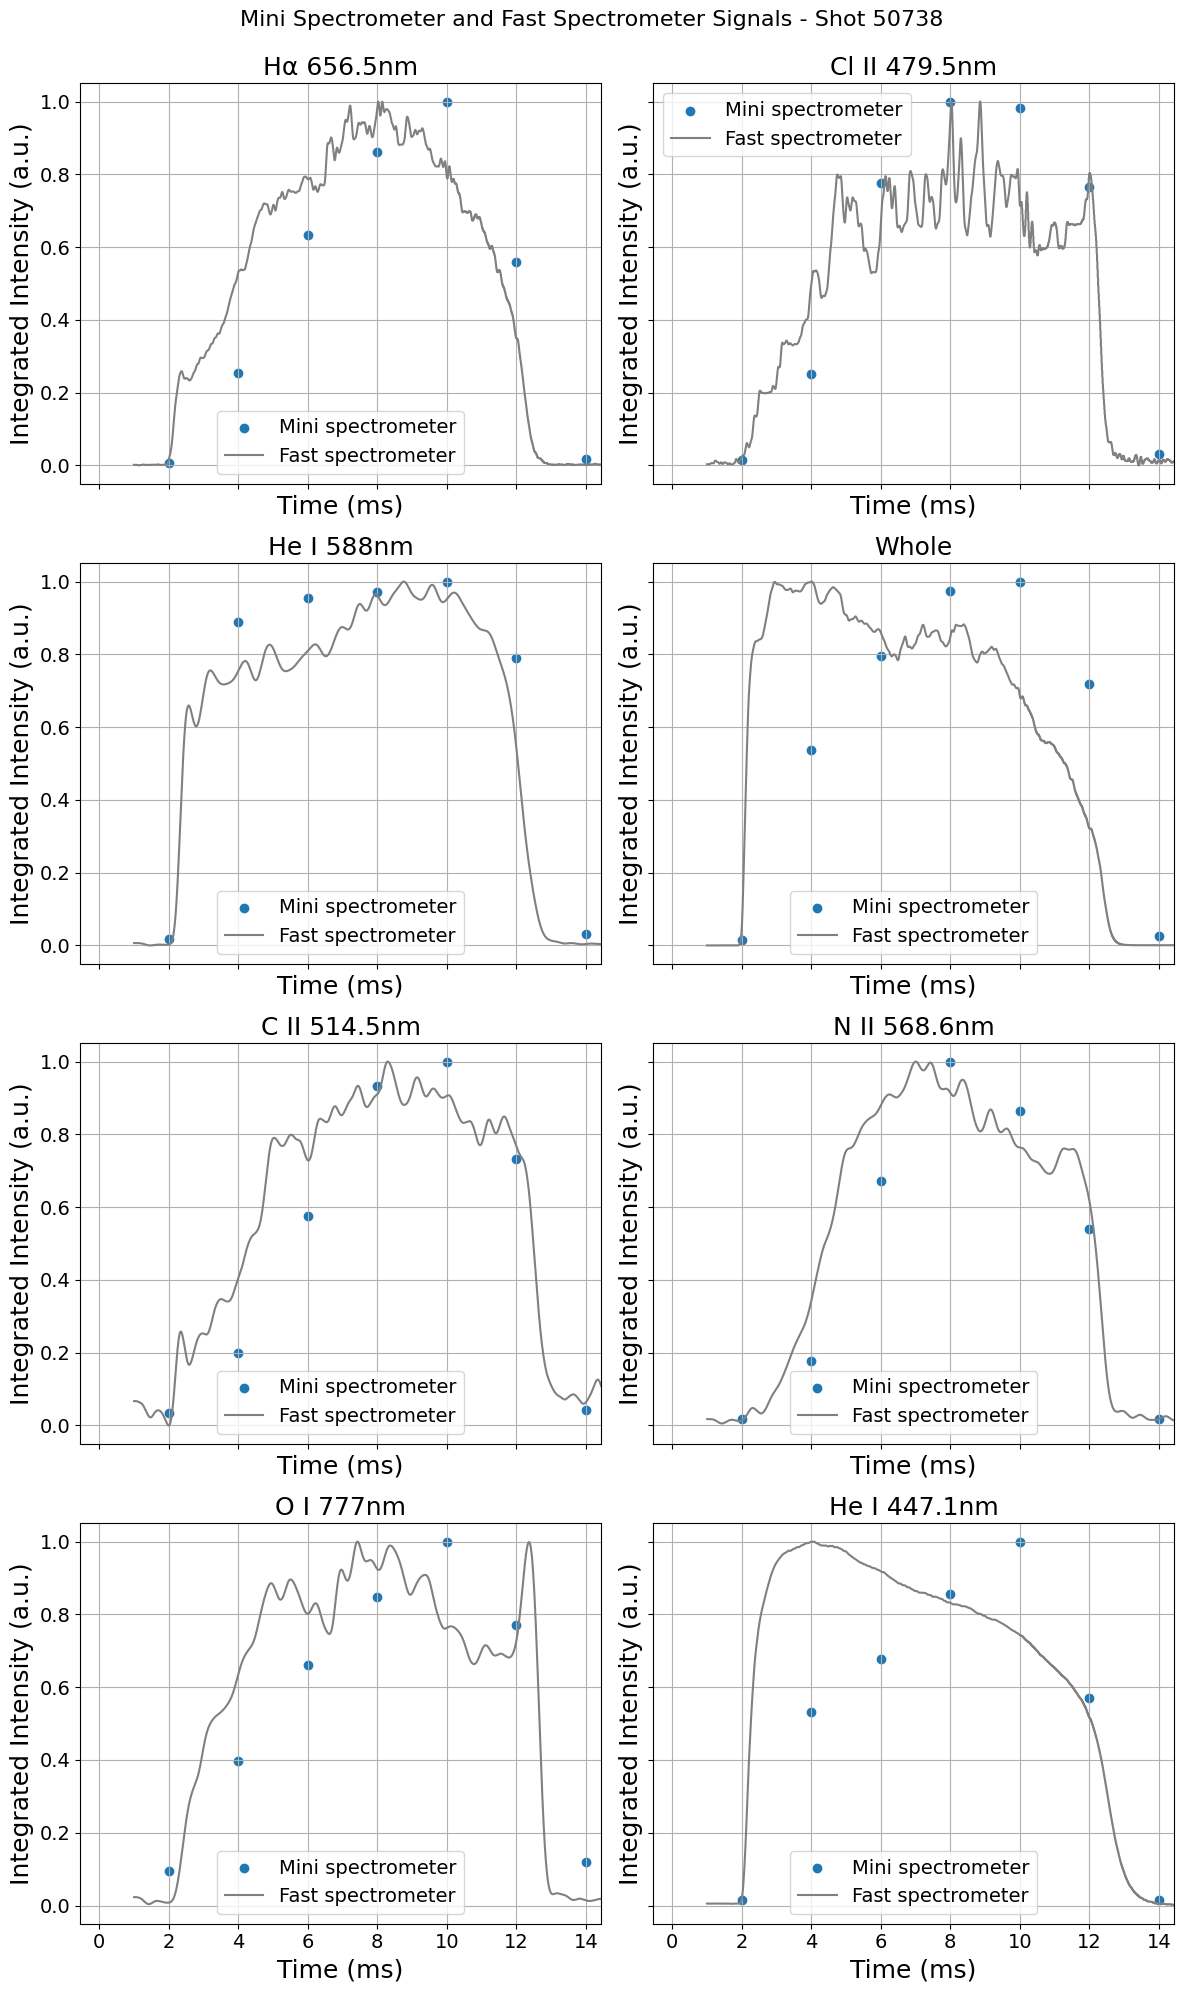

In [ ]:
peaks = [
  {
    "name": "Hα 656.5nm",
    "wavelength": 656.0,
    "fwhm": 10,
    "fs_data": data["Hα 656.5nm"],
    "qe_channel": "Ha656"
  },
  {
    "name": "Cl II 479.5nm",
    "wavelength": 480.0,
    "fwhm": 10,
    "fs_data": data["Cl II 479.5nm"],
    "qe_channel": "ClII479"
  },
  {
    "name": "He I 588nm",
    "wavelength": 590.0,
    "fwhm": 10,
    "fs_data": data["He I 588nm"],
    # "fs_data": data["He I 447.1nm"],
    "qe_channel": "HeI588"
  },
  {
    "name": "Whole",
    "wavelength": 500.0,
    "fwhm": 300,
    "fs_data": data["Whole"],
    "qe_channel": None
  },
  {
    "name": "C II 514.5nm",
    "wavelength": 515.0,
    "fwhm": 10,
    "fs_data": data["C II 514.5nm"],
    "qe_channel": "CII515"
  },
  {
    "name": "N II 568.6nm",
    "wavelength": 570.0,
    "fwhm": 10,
    "fs_data": data["N II 568.6nm"],
    "qe_channel": "NII569"
  },
  {
    "name": "O I 777nm",
    "wavelength": 780.0,
    "fwhm": 10,
    "fs_data": data["O I 777nm"],
    "qe_channel": "O777PP"
  },
  {
    "name": "He I 447.1nm",
    "wavelength": 450.0,
    "fwhm": 10,
    "fs_data": data["He I 447.1nm"],
    # "fs_data": data["He I 588nm"],
    "qe_channel": "HeI447"
  }
]

compare_spectrometer(peaks, Wavelengths, Spectra, qe_data)

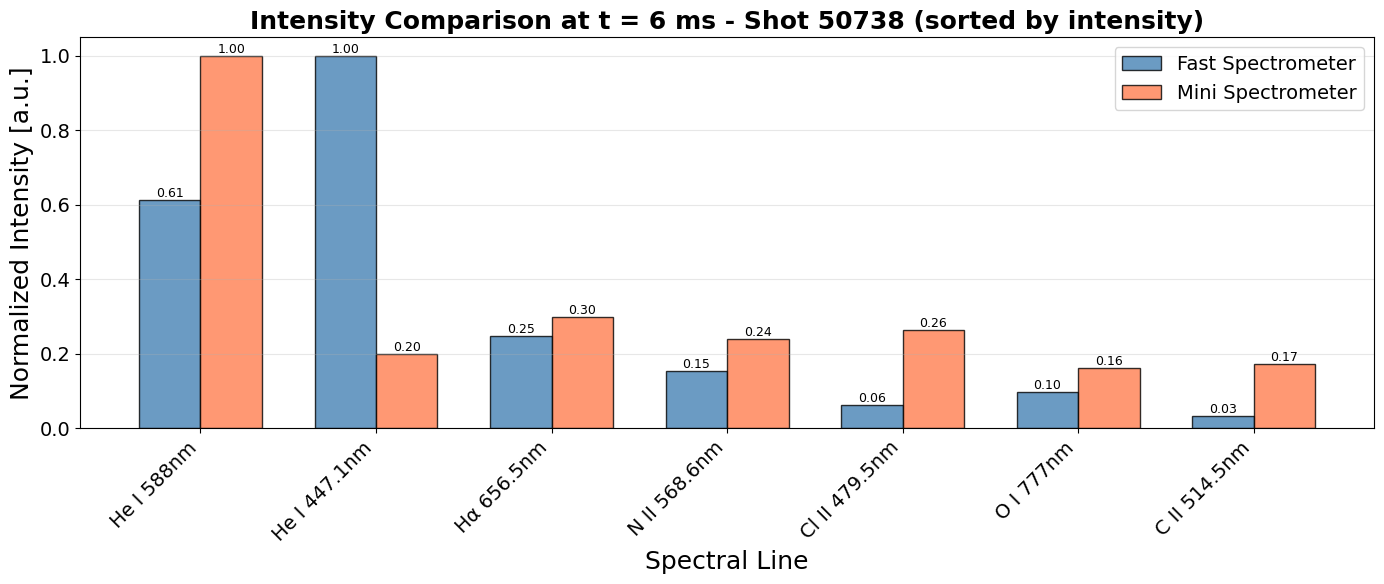


Intensity values at t = 6 ms (sorted by average intensity):
------------------------------------------------------------
He I 588nm          : Fast=0.614, Mini=1.000
He I 447.1nm        : Fast=1.000, Mini=0.201
Hα 656.5nm          : Fast=0.247, Mini=0.299
N II 568.6nm        : Fast=0.154, Mini=0.241
Cl II 479.5nm       : Fast=0.063, Mini=0.264
O I 777nm           : Fast=0.097, Mini=0.162
C II 514.5nm        : Fast=0.033, Mini=0.172


In [22]:
# Time point to compare (in milliseconds)
t = 6  # ms

# Prepare data for histogram
line_names = []
fast_spec_intensities = []
mini_spec_intensities = []

for peak in peaks:
    if peak['name'] == "Whole":
        continue
    
    line_names.append(peak["name"])
    
    # --- Fast Spectrometer intensity at time t ---
    # Get time and intensity data from fast spectrometer
    start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
    t_fs = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
    u_fs = peak["fs_data"].iloc[:, 1][start_index:]
    
    # Interpolate fast spectrometer intensity at time t
    fast_intensity = np.interp(t, t_fs, u_fs)
    fast_spec_intensities.append(fast_intensity)
    
    # --- Mini Spectrometer intensity at time t ---
    # Compute mini spectrometer intensity using the extracted function
    mini_spectrometer_t, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
        Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, peak["qe_channel"]
    )
    
    # Interpolate mini spectrometer intensity at time t
    mini_intensity = np.interp(t, mini_spectrometer_t, mini_spectrometer_intensity)
    mini_spec_intensities.append(mini_intensity)

# Normalize intensities for comparison (each spectrometer separately)
fast_spec_intensities = np.array(fast_spec_intensities)
mini_spec_intensities = np.array(mini_spec_intensities)

# Normalize to 0-1 range
if fast_spec_intensities.max() > 0:
    fast_spec_normalized = fast_spec_intensities / fast_spec_intensities.max()
else:
    fast_spec_normalized = fast_spec_intensities

if mini_spec_intensities.max() > 0:
    mini_spec_normalized = mini_spec_intensities / mini_spec_intensities.max()
else:
    mini_spec_normalized = mini_spec_intensities

# Sort by average intensity (descending order)
avg_intensity = (fast_spec_normalized + mini_spec_normalized) / 2
sort_indices = np.argsort(avg_intensity)[::-1]  # descending order

line_names_sorted = [line_names[i] for i in sort_indices]
fast_spec_sorted = fast_spec_normalized[sort_indices]
mini_spec_sorted = mini_spec_normalized[sort_indices]

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(line_names_sorted))
width = 0.35

bars1 = ax.bar(x - width/2, fast_spec_sorted, width, label='Fast Spectrometer', 
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, mini_spec_sorted, width, label='Mini Spectrometer', 
               color='coral', alpha=0.8, edgecolor='black')

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Spectral Line')
ax.set_ylabel('Normalized Intensity [a.u.]')
ax.set_title(f'Intensity Comparison at t = {t} ms - Shot {shotno} (sorted by intensity)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(line_names_sorted, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nIntensity values at t = {t} ms (sorted by average intensity):")
print("-" * 60)
for i, name in enumerate(line_names_sorted):
    print(f"{name:20s}: Fast={fast_spec_sorted[i]:.3f}, Mini={mini_spec_sorted[i]:.3f}")


Fast spectrometer data shape: (8, 20)
Mini spectrometer data shape: (8, 20)
Applied per-timestep normalization across all spectral lines


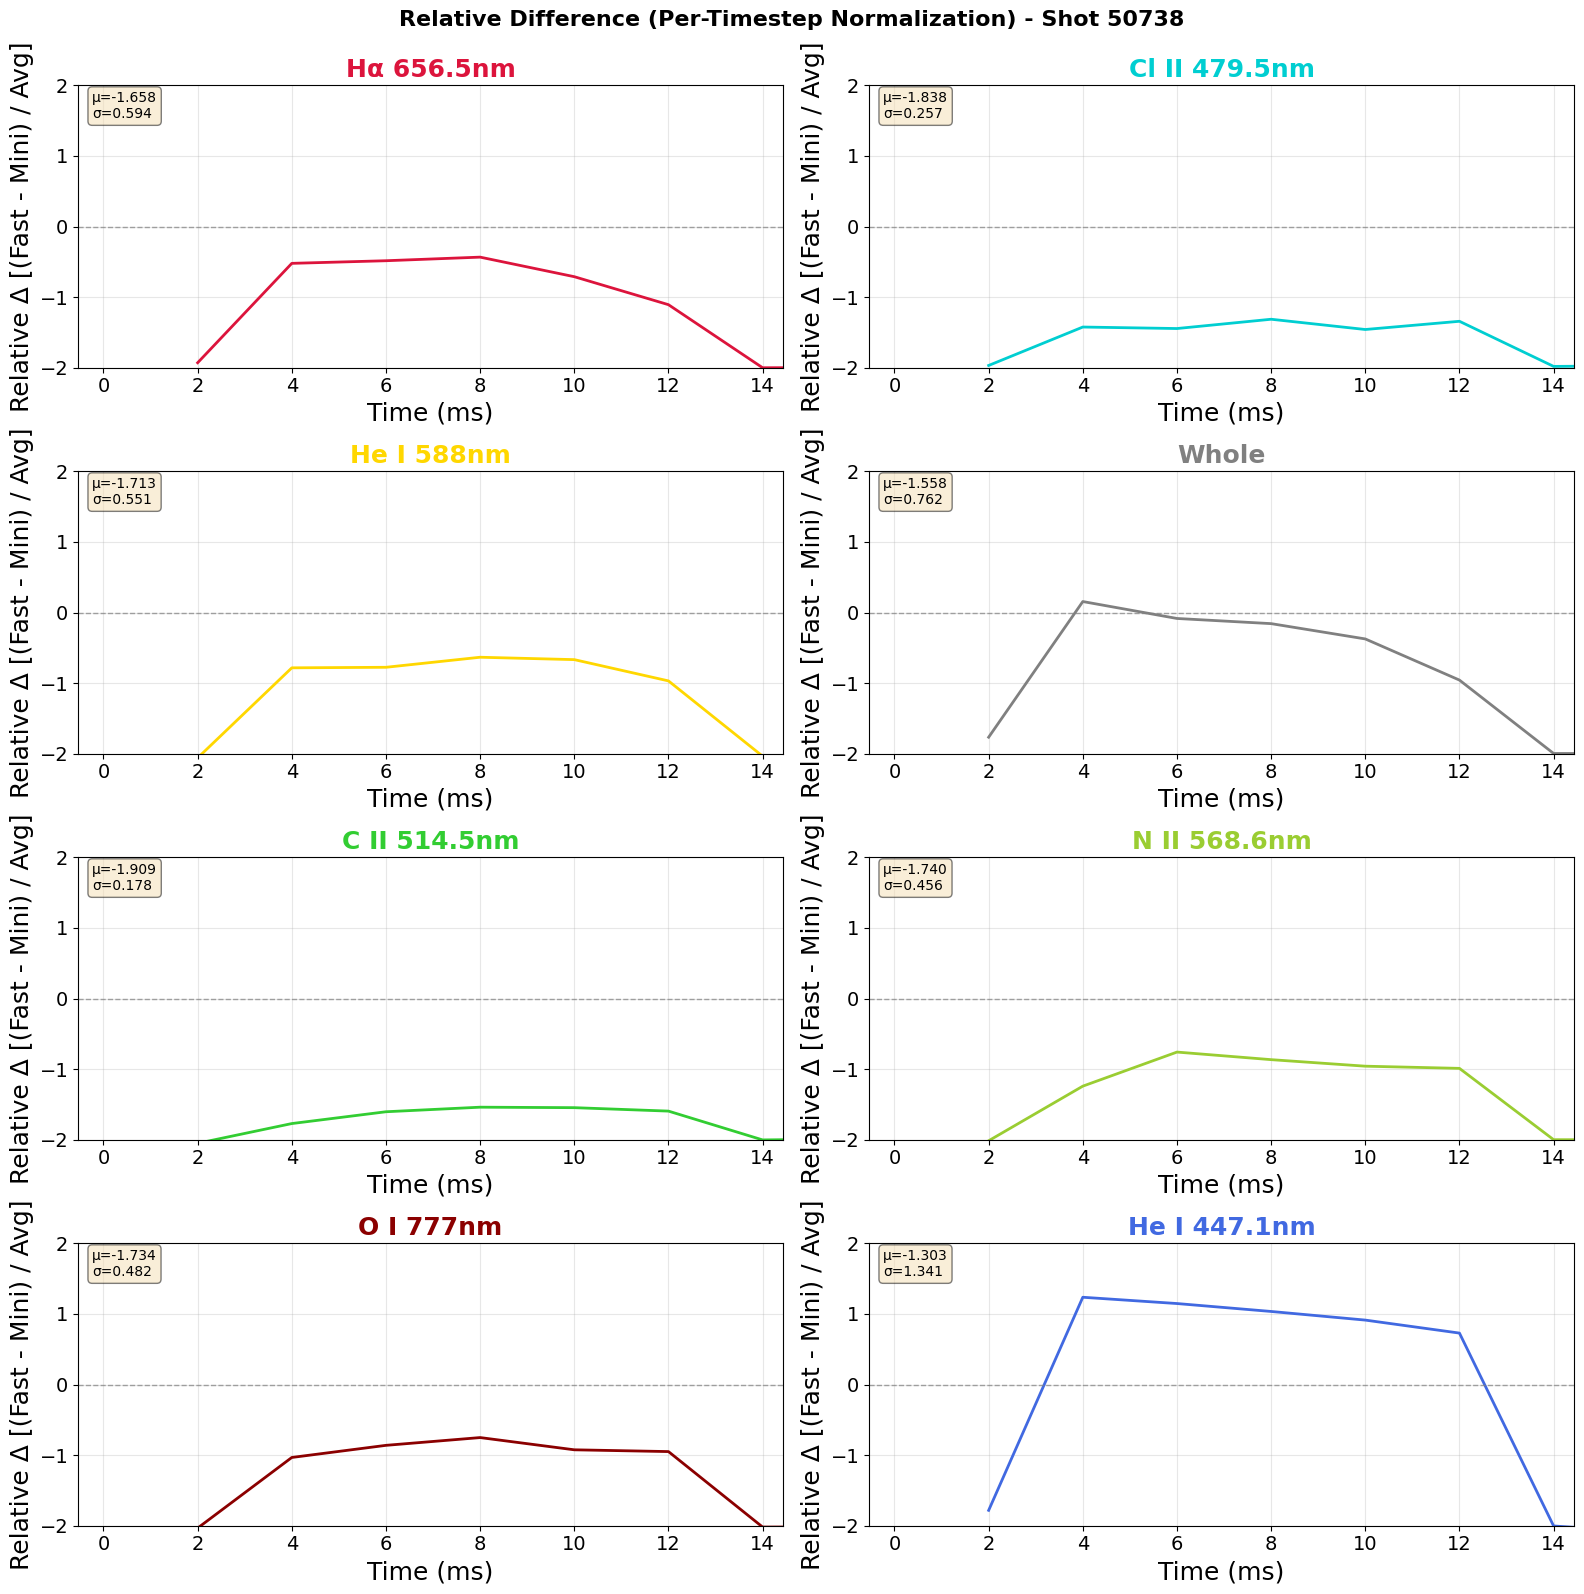

In [23]:
# Plot the difference between normalized fast and mini spectrometer signals
# Apply normalization at each time step separately across all spectral lines

# First pass: collect all data and interpolate to common time base
all_fast_data = []
all_mini_data = []

# Get mini spectrometer time array (common for all lines)
mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)

for peak in peaks:
    # if peak['name'] == "Whole":
    #     continue
    # --- Fast Spectrometer signal ---
    start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
    t_fs = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
    u_fs = peak["fs_data"].iloc[:, 1][start_index:]
    filtered_fs = butter_lowpass_filter(u_fs, 2000, 100e3)
    
    # Interpolate fast spectrometer to mini spectrometer time base
    fast_interpolated = np.interp(mini_spectrometer_t, t_fs, filtered_fs)
    all_fast_data.append(fast_interpolated)
    
    # --- Mini Spectrometer signal ---
    _, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
        Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, peak["qe_channel"]
    )
    all_mini_data.append(mini_spectrometer_intensity)

# Convert to numpy arrays for easier manipulation (shape: [n_lines, n_timepoints])
all_fast_data = np.array(all_fast_data)
all_mini_data = np.array(all_mini_data)

print(f"Fast spectrometer data shape: {all_fast_data.shape}")
print(f"Mini spectrometer data shape: {all_mini_data.shape}")

fast_max_global = np.max(all_fast_data[1:-1,:])
mini_max_global = np.max(all_mini_data)

# Normalize at each time step across all spectral lines
# For each time point, normalize all 8 spectral line values together
normalized_fast = np.zeros_like(all_fast_data)
normalized_mini = np.zeros_like(all_mini_data)

for t_idx in range(all_fast_data.shape[1]):
    # Get all spectral line values at this time point
    fast_at_t = all_fast_data[:, t_idx]
    mini_at_t = all_mini_data[:, t_idx]
    
    # Normalize across spectral lines at this time point
    fast_min, fast_max = fast_at_t.min(), fast_at_t.max()
    mini_min, mini_max = mini_at_t.min(), mini_at_t.max()
    
    normalized_fast[:, t_idx] =  fast_at_t /fast_max_global

    normalized_mini[:, t_idx] = mini_at_t / mini_max_global

print("Applied per-timestep normalization across all spectral lines")

# Second pass: plot with per-timestep normalization
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes_flat = axes.flatten()

for n, peak in enumerate(peaks):
    # Get the normalized data for this spectral line
    normalized_fs = normalized_fast[n, :]
    normalized_mini_line = normalized_mini[n, :]
    
    # Calculate relative difference: (fast - mini) / average
    average = (normalized_fs + normalized_mini_line) / 2
    epsilon = 1e-10
    relative_difference = (normalized_fs - normalized_mini_line) / (average + epsilon)
    
    # Plot on the corresponding axis
    ax = axes_flat[n]
    ax.plot(mini_spectrometer_t, relative_difference, linewidth=2, 
            color=line_colors.get(peak['name'], 'black'))
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Relative Δ [(Fast - Mini) / Avg]')
    ax.set_title(f"{peak['name']}", 
                 color=line_colors.get(peak['name'], 'black'), 
                 fontweight='bold')
    
    # Set xlim based on plasma timing if available
    if loader.plasma_timing:
        ax.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, 
                    loader.plasma_timing.t_plasma_end_ms + 2)
    
    # Set consistent y-axis limits across all subplots
    ax.set_ylim(-2, 2)
    
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    mean_diff = np.mean(relative_difference)
    std_diff = np.std(relative_difference)
    ax.text(0.02, 0.98, f'μ={mean_diff:.3f}\nσ={std_diff:.3f}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle(f'Relative Difference (Per-Timestep Normalization) - Shot {shotno}', 
             fontsize=16, y=0.995, fontweight='bold')
fig.tight_layout()
plt.show()


## Demonstration: Mini-Spectrometer Data to Time-Dependent Signal Conversion

This visualization shows how the `compare_spectrometer` function converts full spectral data into time-dependent signals by:
1. Selecting a wavelength region around a spectral line (peak ± FWHM/2)
2. Applying quantum efficiency weights to account for optical system response
3. Integrating the weighted intensity over that wavelength range
4. Repeating for each time point to create a time series

Wavelengths shape: (2047,), Spectra shape: (20, 2048)
Selected spectrum index 4 (t = 8 ms) with max Hα intensity


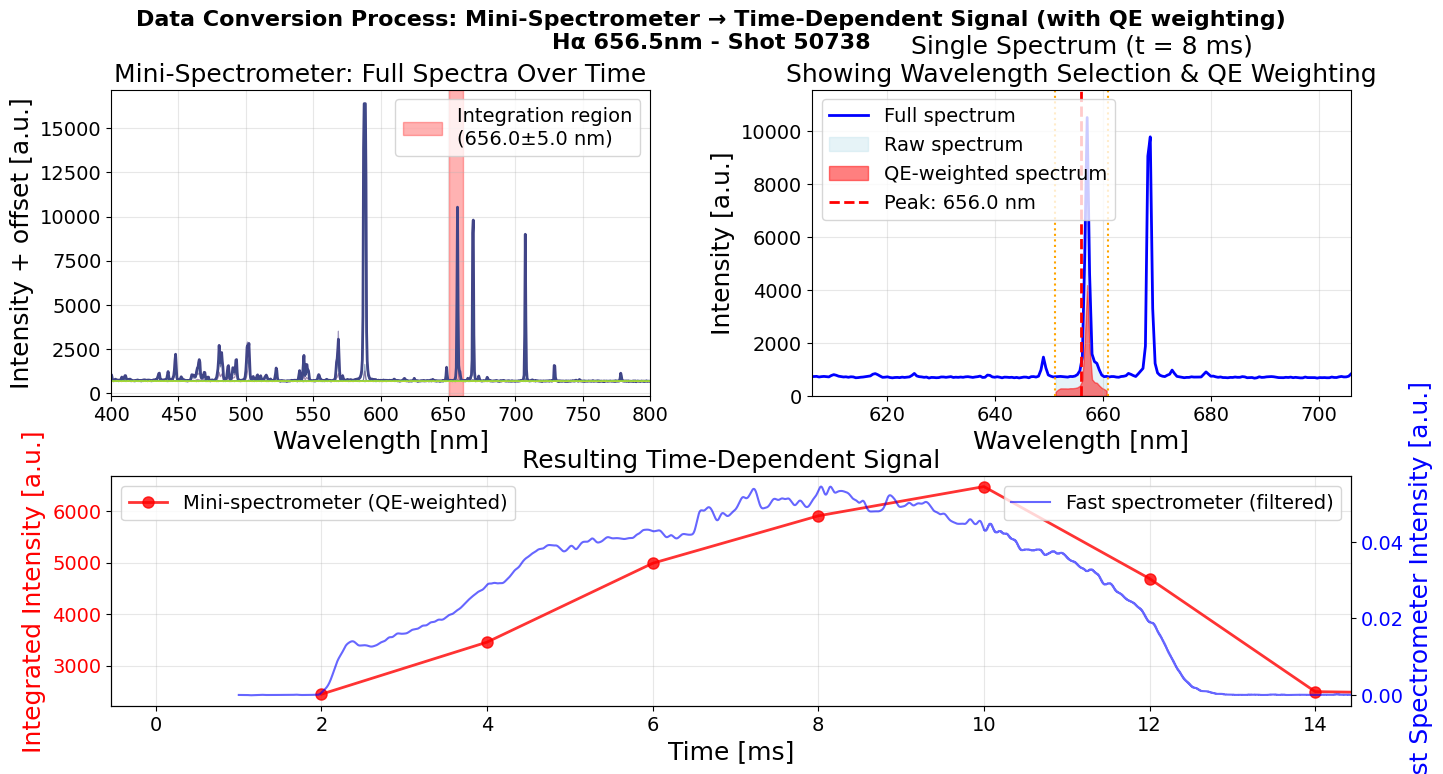

In [24]:
# Demonstration of data conversion for Hα line
peak_demo = {
    "name": "Hα 656.5nm",
    "wavelength": 656.0,
    "fwhm": 10,
    "fs_data": data["Hα 656.5nm"],
    "qe_channel": "Ha656"
}

# Check dimensions and fix if needed
print(f"Wavelengths shape: {Wavelengths.shape}, Spectra shape: {Spectra.shape}")

# Find the spectrum with the strongest Hα signal
min_len_check = min(len(Wavelengths), len(Spectra[0]))
wavelength_mask_check = (Wavelengths[:min_len_check] >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                        (Wavelengths[:min_len_check] <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
wavelength_indexes_check = np.where(wavelength_mask_check)[0]

# Calculate integrated intensity for each spectrum to find the peak
intensities = []
for i in range(len(Spectra)):
    spectrum_slice = Spectra[i][wavelength_indexes_check]
    total = np.trapezoid(spectrum_slice, Wavelengths[wavelength_indexes_check])
    intensities.append(total)

# Choose spectrum with maximum Hα intensity (should be around plasma peak)
demo_spectrum_idx = np.argmax(intensities)
print(f"Selected spectrum index {demo_spectrum_idx} (t = {demo_spectrum_idx*2} ms) with max Hα intensity")

# Create a comprehensive visualization
fig = plt.figure(figsize=(16, 8))

# Define grid for subplot layout
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1.5], hspace=0.3, wspace=0.3)

# --- Top left: 3D-like view of spectra over time ---
ax1 = fig.add_subplot(gs[0, 0])

# Show every spectrum to see the evolution
step = 1
for i in range(0, len(Spectra), step):
    # Ensure we only use the overlapping part
    min_len = min(len(Wavelengths), len(Spectra[i]))
    # Offset each spectrum vertically for 3D effect
    offset = i * 0.5
    alpha_val = 1.0 if i == demo_spectrum_idx else 0.5
    lw = 2 if i == demo_spectrum_idx else 0.8
    ax1.plot(Wavelengths[:min_len], Spectra[i][:min_len] + offset, 
             alpha=alpha_val, linewidth=lw, color=plt.cm.viridis(i/len(Spectra)))

# Highlight the wavelength region of interest
wavelength_mask = (Wavelengths >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                  (Wavelengths <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
ax1.axvspan(peak_demo["wavelength"] - peak_demo["fwhm"]/2, 
            peak_demo["wavelength"] + peak_demo["fwhm"]/2, 
            alpha=0.3, color='red', label=f'Integration region\n({peak_demo["wavelength"]}±{peak_demo["fwhm"]/2} nm)')

ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Intensity + offset [a.u.]')
ax1.set_title('Mini-Spectrometer: Full Spectra Over Time')
ax1.set_xlim(400, 800)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- Top right: Single spectrum showing wavelength selection ---
ax2 = fig.add_subplot(gs[0, 1])

# Use the spectrum with maximum Hα intensity
min_len = min(len(Wavelengths), len(Spectra[demo_spectrum_idx]))
ax2.plot(Wavelengths[:min_len], Spectra[demo_spectrum_idx][:min_len], 'b-', linewidth=2, label='Full spectrum')

# Highlight the selected wavelength region - recalculate mask for the correct length
wavelength_mask_ax2 = (Wavelengths[:min_len] >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                       (Wavelengths[:min_len] <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
wavelength_indexes = np.where(wavelength_mask_ax2)[0]

# Get quantum efficiency for this wavelength range
qe_weights_demo = np.interp(Wavelengths[wavelength_indexes], 
                             qe_data['Wavelength (nm)'], 
                             qe_data[peak_demo["qe_channel"]],
                             left=0, right=0)
weighted_spectrum = Spectra[demo_spectrum_idx][wavelength_indexes] * qe_weights_demo

ax2.fill_between(Wavelengths[wavelength_indexes], 
                 0, 
                 Spectra[demo_spectrum_idx][wavelength_indexes], 
                 alpha=0.3, color='lightblue', label='Raw spectrum')

ax2.fill_between(Wavelengths[wavelength_indexes], 
                 0, 
                 weighted_spectrum, 
                 alpha=0.5, color='red', label='QE-weighted spectrum')

ax2.axvline(peak_demo["wavelength"], color='red', linestyle='--', linewidth=2, label=f'Peak: {peak_demo["wavelength"]} nm')
ax2.axvline(peak_demo["wavelength"] - peak_demo["fwhm"]/2, color='orange', linestyle=':', linewidth=1.5)
ax2.axvline(peak_demo["wavelength"] + peak_demo["fwhm"]/2, color='orange', linestyle=':', linewidth=1.5)

ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Intensity [a.u.]')
ax2.set_title(f'Single Spectrum (t = {demo_spectrum_idx*2} ms)\nShowing Wavelength Selection & QE Weighting')
ax2.set_xlim(peak_demo["wavelength"] - 50, peak_demo["wavelength"] + 50)
# Set ylim to focus on the region with the peak
y_min = Spectra[demo_spectrum_idx][wavelength_indexes].min() * 0.9
y_max = Spectra[demo_spectrum_idx][wavelength_indexes].max() * 1.1
ax2.set_ylim(0, y_max)
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Bottom: Resulting time-dependent signal ---
ax4 = fig.add_subplot(gs[1, :])

# Compute mini spectrometer intensity using the extracted function
mini_spectrometer_t, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
    Spectra, Wavelengths, peak_demo["wavelength"], peak_demo["fwhm"], qe_data, peak_demo["qe_channel"]
)

# Plot both mini spectrometer and fast spectrometer
ax4.plot(mini_spectrometer_t, mini_spectrometer_intensity, 'ro-', 
         markersize=8, linewidth=2, label='Mini-spectrometer (QE-weighted)', alpha=0.8)

# Add fast spectrometer comparison
start_index = np.nonzero(peak_demo["fs_data"].iloc[:, 0] > 1e-3)[0][0]
t_fs = peak_demo["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
u_fs = peak_demo["fs_data"].iloc[:, 1][start_index:]
filtered_fs = butter_lowpass_filter(u_fs, 2000, 100e3)

# Normalize both for comparison
ax4_twin = ax4.twinx()
ax4_twin.plot(t_fs, filtered_fs, 'b-', alpha=0.6, linewidth=1.5, label='Fast spectrometer (filtered)')
ax4_twin.set_ylabel('Fast Spectrometer Intensity [a.u.]', color='b')
ax4_twin.tick_params(axis='y', labelcolor='b')

ax4.set_xlabel('Time [ms]')
ax4.set_ylabel('Integrated Intensity [a.u.]', color='r')
ax4.set_title('Resulting Time-Dependent Signal')
ax4.tick_params(axis='y', labelcolor='r')

# Set xlim based on plasma timing if available
if loader.plasma_timing:
    ax4.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, loader.plasma_timing.t_plasma_end_ms + 2)

ax4.grid(True, alpha=0.3)
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

fig.suptitle(f'Data Conversion Process: Mini-Spectrometer → Time-Dependent Signal (with QE weighting)\n{peak_demo["name"]} - Shot {shotno}', 
             fontsize=16, fontweight='bold')

plt.show()